
## Speech Emotion Recognition

### Files

This portion of the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

### File naming convention:

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03) Speech (01) Fearful (06) Normal intensity (01) Statement "dogs" (02) 1st Repetition (01) 12th Actor (12) Female, as the actor ID number is even.

## EXPLORATORY DATA ANALYSIS

The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients) and Mel Spectrogram

MFCC (Mel Frequency Cepstral Coefficients)- MFCC is important feature extraction when using speech data,Mel scale is a scale that relates the perceived frequency of a tone to the real measured frequency. It scales the frequency so that you can fit greater carefully what the human ear can hear
Mel Spectrogram- A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and what is the spectrogram , Spectrogram is visual way of representation of signal strength and also use for display the frequency sound waves.
For the EDA we have used MFCC and Mel Spectogram

In [1]:
#Install all the Reqiuired Libraries and Packages 
import sys
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
from IPython.display import Audio
get_ipython().magic('matplotlib inline')
import soundfile
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
import IPython.display as ipd
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24')
#'"D:\4th Year sem2\RAVDESS_dataset\audio_speech_actors_01-24"'
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = '/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1441

In [3]:
import os
import pandas as pd

RAVD = '/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/'

dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
path = []
for i in dirl_list:
    if i.endswith('.DS_Store'):  # Skip .DS_Store file
        continue
    fname = os.listdir(RAVD + i)
    for f in fname:
        if f.endswith('.DS_Store'):  # Skip .DS_Store file
            continue
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        path.append(RAVD + i + '/' + f)


RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAVD_df.columns = ['emotion']
RAVD_df['labels'] = RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAVD_df = RAVD_df.drop(['emotion'], axis=1)
RAVD_df.labels.value_counts()


surprise    192
angry       192
fear        192
disgust     192
sad         192
happy       192
calm        192
neutral      96
Name: labels, dtype: int64

In [4]:
RAVD_df

labels   source                                               path
0     surprise  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
1     surprise  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
2        angry  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
3         fear  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
4         fear  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
...        ...      ...                                                ...
1435      fear  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
1436      fear  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
1437     angry  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
1438  surprise  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...
1439  surprise  RAVDESS  /Users/praneethnpbmacpro/Downloads/RAVDESS/aud...

[1440 rows x 3 columns]

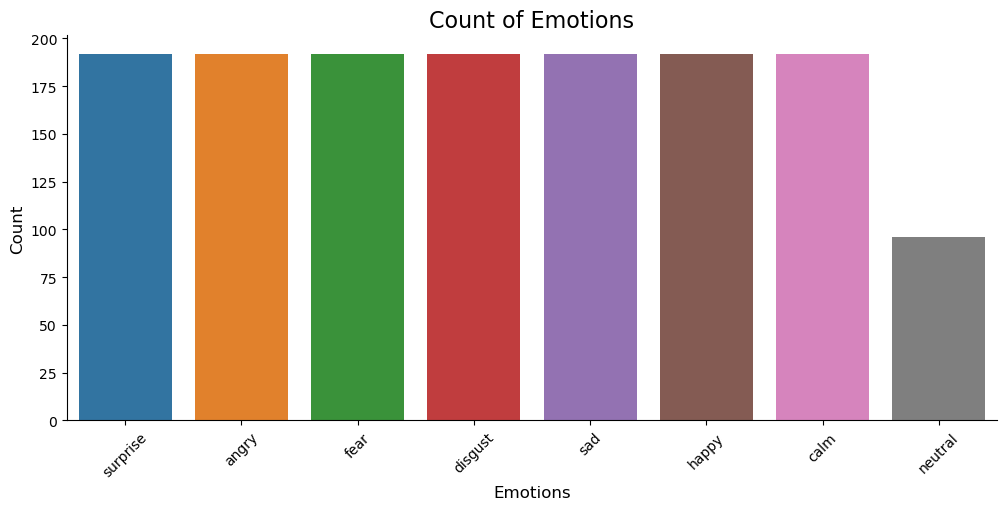

In [5]:
#Plot of no.of Emotions
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(x=RAVD_df['labels'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data Visualization

#### Male Neutral

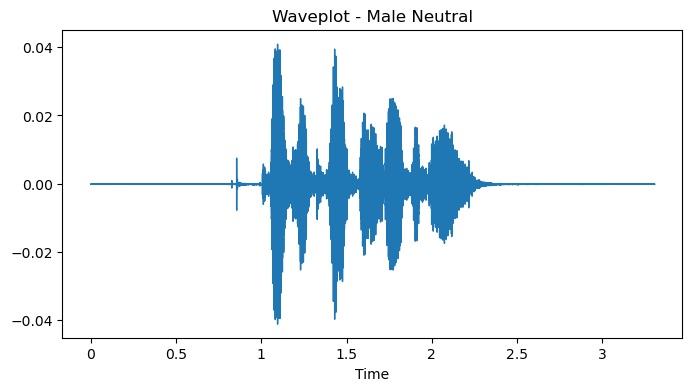

In [6]:
#### Male Nuetral

x,sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
# plt.savefig('Waveplot_MaleNeutral.png')

# PLAY AUDIO FILE
Audio(data=x, rate=sr)

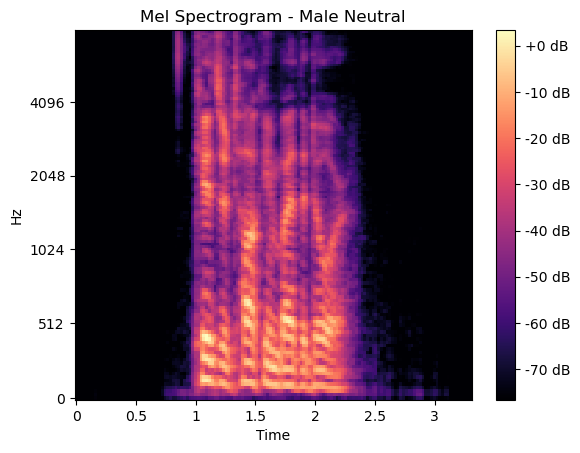

In [7]:
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB')

#### Female Calm

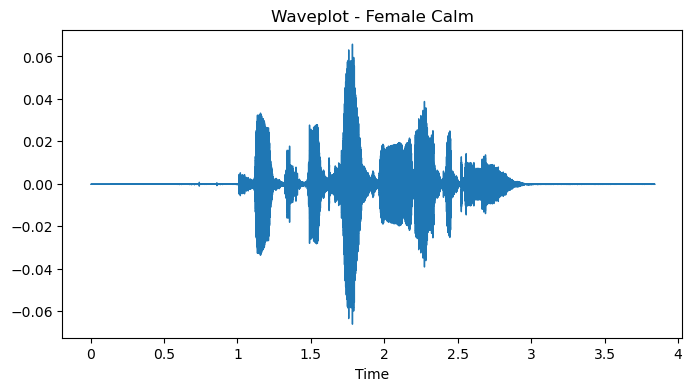

In [8]:
#### Female Calm

x,sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-02-01-01-01-02.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Calm')
# plt.savefig('Waveplot_MaleNeutral.png')

# PLAY AUDIO FILE
Audio(data=x, rate=sr)

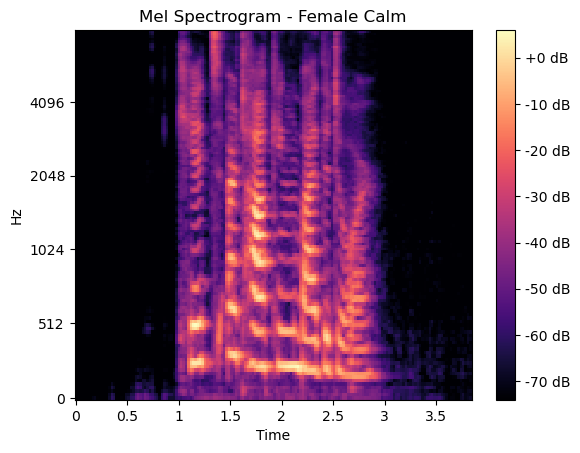

In [9]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Calm')
plt.savefig('MelSpec_FemaleCalm.png')
plt.colorbar(format='%+2.0f dB')

#### Male Happy

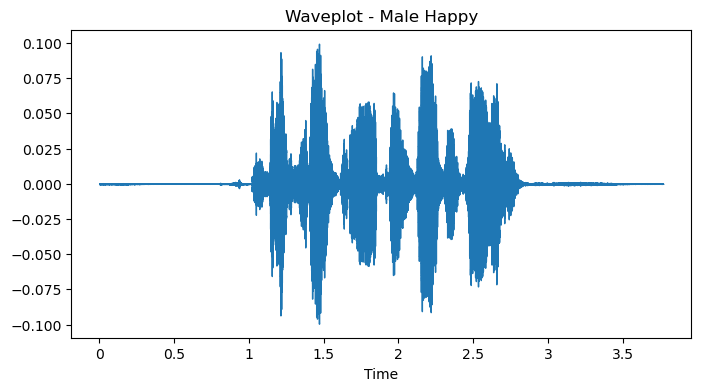

In [10]:

# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-03-01-01-01-03.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Happy')
# plt.savefig('Waveplot_MaleHappy.png')

Audio(data=x, rate=sr)



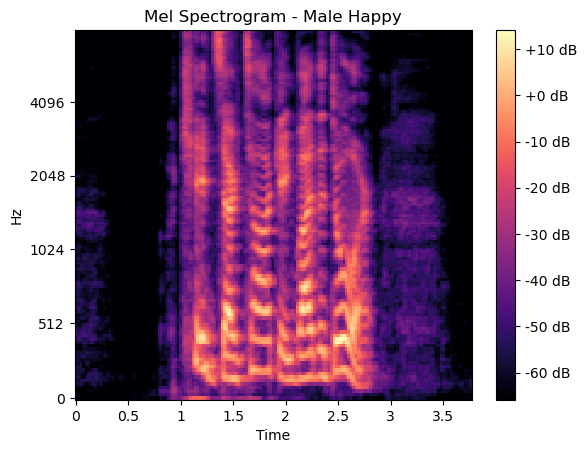

In [11]:
# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
x = librosa.power_to_db(x)

librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Happy')
plt.savefig('MelSpec_MaleHappy.png')
plt.colorbar(format='%+2.0f dB')

#### Female Sad

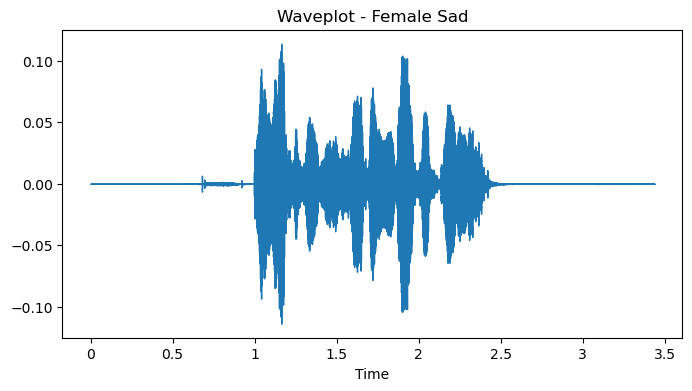

In [12]:
# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-04-01-02-01-04.wav')


# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Sad')
plt.savefig('Waveplot_FemaleSad.png')

Audio(data=x, rate=sr)

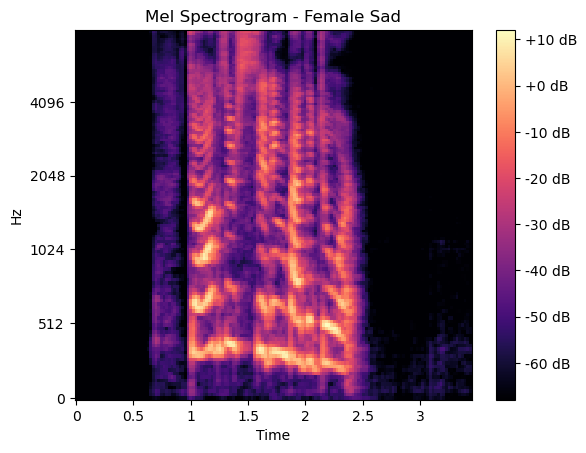

In [13]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Sad')
plt.savefig('MelSpec_FemaleSad.png')
plt.colorbar(format='%+2.0f dB')

#### Male Angry


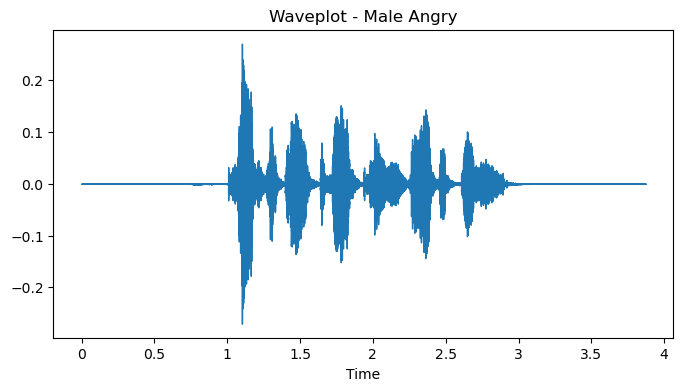

In [14]:
# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-05-01-01-01-05.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Angry')
plt.savefig('Waveplot_MaleAngry.png')

Audio(data=x, rate=sr)


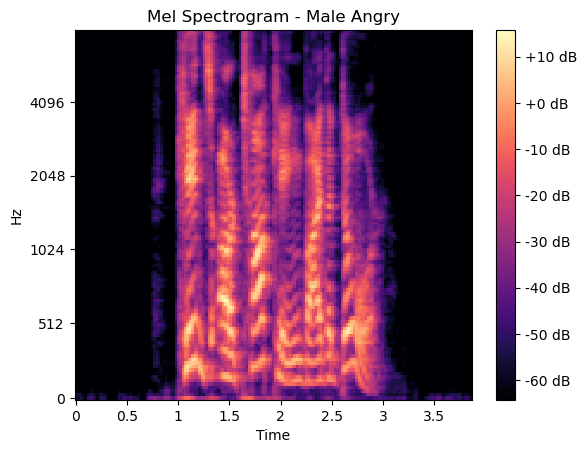

In [15]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Angry')
plt.savefig('MelSpec_MaleAngry.png')
plt.colorbar(format='%+2.0f dB')

#### Female Fearful


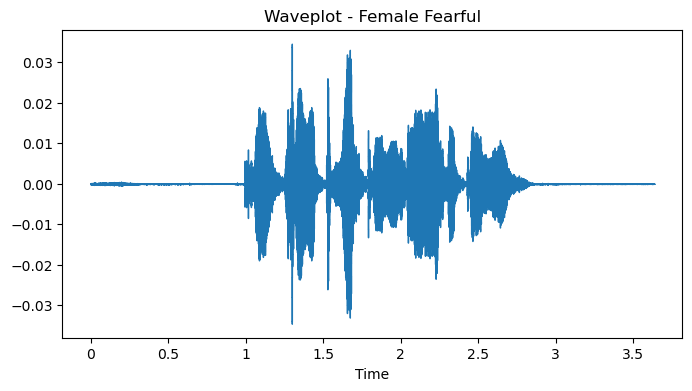

In [16]:
# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-06-01-01-01-06.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Fearful')
plt.savefig('Waveplot_FemaleFearful.png')

Audio(data=x, rate=sr)

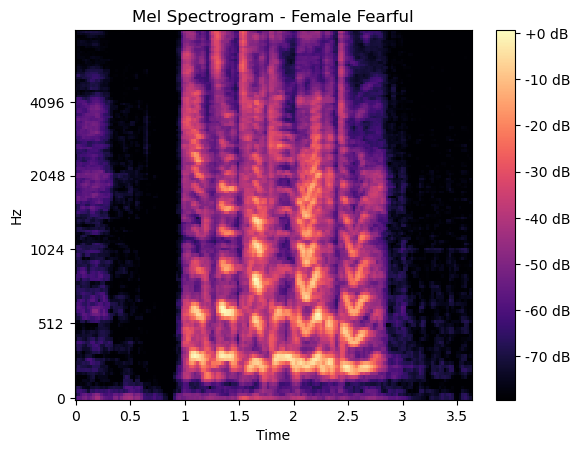

In [17]:
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Fearful')
plt.savefig('MelSpec_FemaleFearful.png')
plt.colorbar(format='%+2.0f dB')

#### Male Disgust


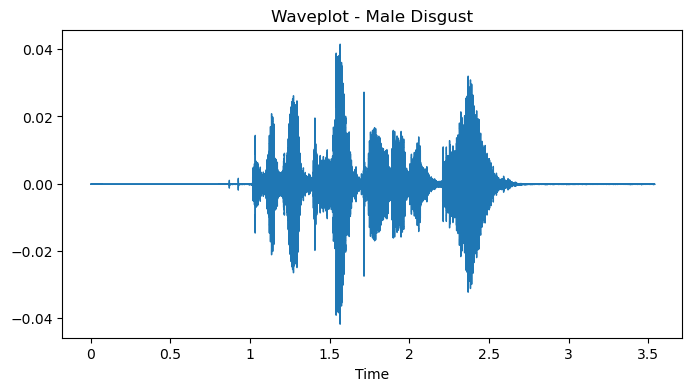

In [18]:

# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_07/03-01-07-01-01-01-07.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Disgust')
plt.savefig('Waveplot_MaleDisgust.png')

Audio(data=x, rate=sr)

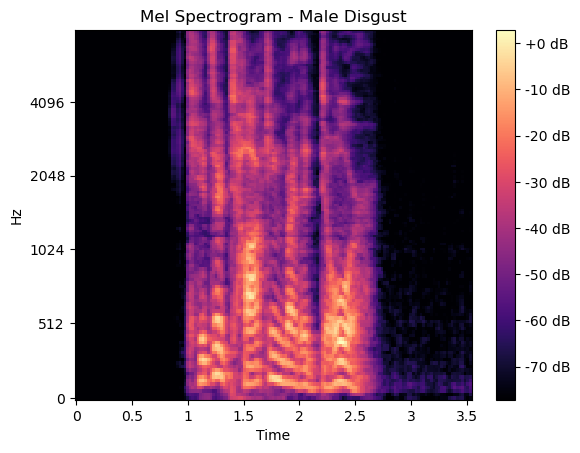

In [19]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Disgust')
plt.savefig('MelSpec_MaleDisgust.png')
plt.colorbar(format='%+2.0f dB')

#### Female Surprised


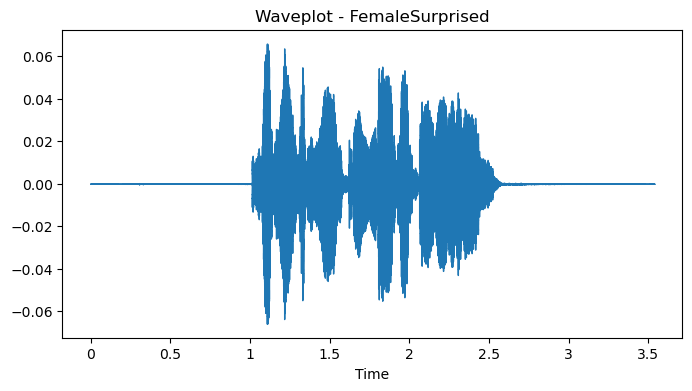

In [20]:

# LOAD FILE
x, sr = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-08-02-01-02-18.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - FemaleSurprised')
plt.savefig('Waveplot_FemaleSurprised.png')

Audio(data=x, rate=sr)

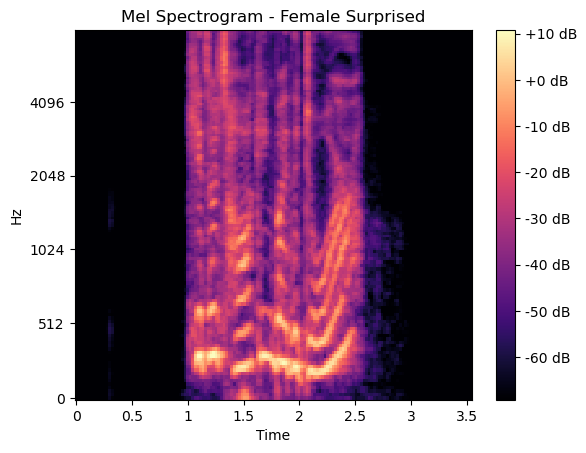

In [21]:

# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Surprised')
plt.savefig('MelSpec_FemaleSurprised.png')
plt.colorbar(format='%+2.0f dB')

### MFCCs of some emotions

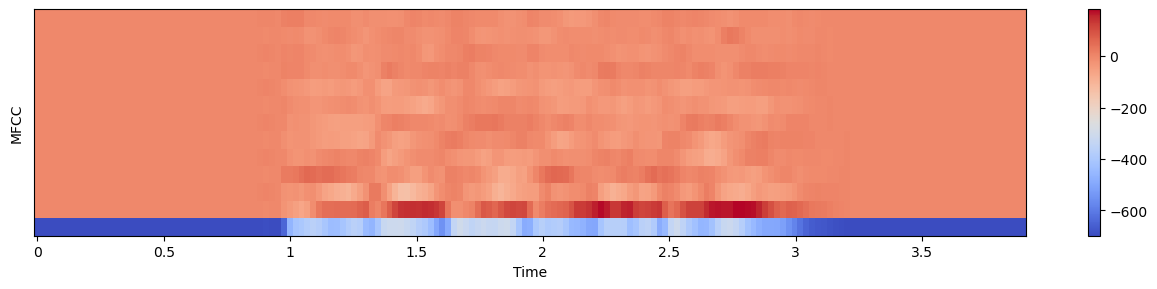

In [22]:
# Gender - Female; Emotion - Angry 
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

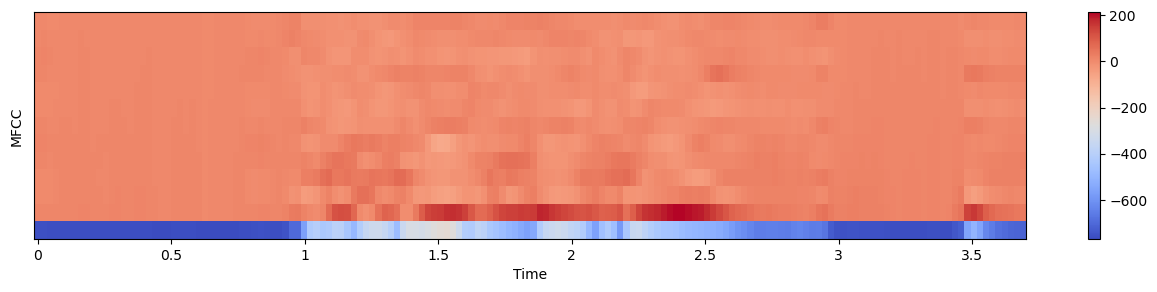

In [23]:
# Gender - Male; Emotion - Angry 
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
#Audio
ipd.Audio(path)

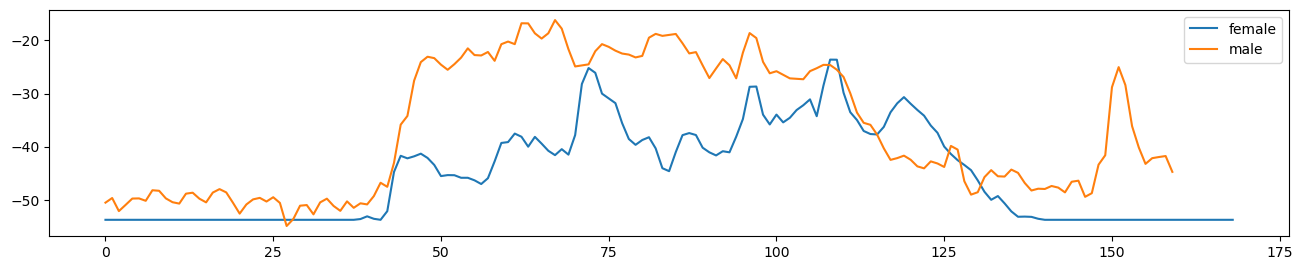

In [24]:
# Gender - Female; Emotion - angry
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)


# Gender - Male; Emotion - angry
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24//Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)


# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

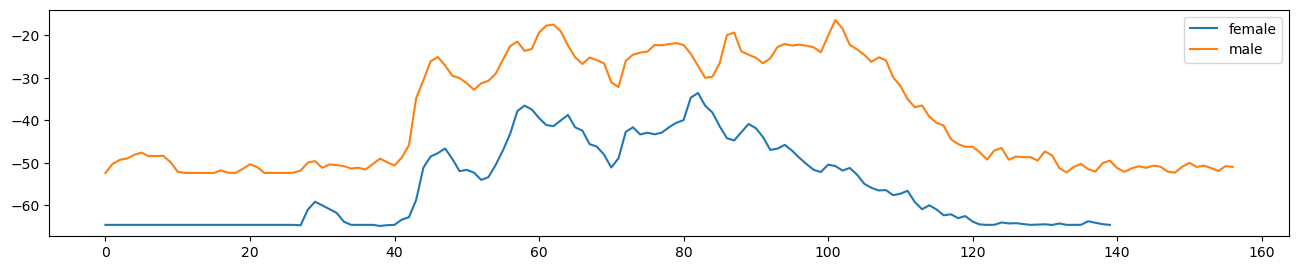

In [25]:
# Gender - Female; Emotion - Surprised
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-08-02-01-02-20.wav"
X, sample_rate = librosa.load(path)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)


# Gender - Male; Emotion - Surprised
path = "/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24/Actor_21/03-01-08-02-01-01-21.wav"
X, sample_rate = librosa.load(path)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)


# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Again we combine the emotion of suprised male female then again male has higher pitch

In [26]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOICES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

### The clean Audio Files are redirected to Clean Audio Folder Directory 

In [27]:
import glob,pickle
for file in tqdm(glob.glob('/Users/praneethnpbmacpro/Downloads/RAVDESS/audio_speech_actors_01-24//*//*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename='/Users/praneethnpbmacpro/Downloads/RAVDESS/clean_speech//'+str(file_name), rate=rate,data=signal[mask])

100%|███████████████████████████████████████| 1440/1440 [00:16<00:00, 88.14it/s]


## Feature Extraction

In [28]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [29]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust','surprised','neutral','angry','sad']

## Data Splitting

In [30]:
#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob('/Users/praneethnpbmacpro/Downloads/RAVDESS/clean_speech//*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [31]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data()
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(964, 180) (476, 180) (964, 2) (476, 2)
(964,) (476,)
03-01-06-02-02-02-15.wav
03-01-07-02-02-01-12.wav
03-01-02-02-01-02-13.wav
03-01-06-02-02-02-06.wav
03-01-06-02-01-01-19.wav
03-01-06-02-01-02-18.wav
03-01-08-02-01-01-14.wav
03-01-06-02-01-01-24.wav
03-01-04-02-02-01-06.wav
03-01-02-02-02-01-15.wav
03-01-05-01-01-02-24.wav
03-01-01-01-02-02-16.wav
03-01-07-01-02-02-12.wav
03-01-07-02-01-01-22.wav
03-01-02-02-01-01-15.wav
03-01-05-01-01-02-16.wav
03-01-02-01-01-02-12.wav
03-01-03-01-01-01-09.wav
03-01-02-02-02-01-03.wav
03-01-08-02-01-01-09.wav
03-01-03-01-01-02-07.wav
03-01-03-02-01-01-11.wav
03-01-02-01-02-01-15.wav
03-01-06-01-01-01-08.wav
03-01-04-01-01-01-20.wav
03-01-06-01-01-01-11.wav
03-01-08-01-01-01-14.wav
03-01-04-01-02-01-06.wav
03-01-08-01-02-01-04.wav
03-01-06-02-01-01-14.wav
03-01-07-02-02-01-01.wav
03-01-03-02-01-01-10.wav
03-01-05-02-01-02-10.wav
03-01-07-02-02-01-04.wav
03-01-07-01-02-02-21.wav
03-01-05-01-02-01-06.wav
03-01-04-02-02-02-05.wav
03-01-03-01-02-02-15.

In [32]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-3.69703674e+02,  8.69062424e+01, -4.93044758e+00,  2.77432194e+01,
       -7.37602854e+00, -5.98489809e+00, -1.27735081e+01, -1.43911304e+01,
       -1.70103722e+01,  8.18902016e+00, -2.11889057e+01,  4.49670219e+00,
       -9.46708488e+00, -4.08734703e+00, -4.91919804e+00, -6.98476553e+00,
       -1.24197340e+00,  1.39895871e-01, -4.82761097e+00, -2.88767958e+00,
       -7.13129091e+00, -1.90945756e+00, -3.52066970e+00, -3.14763713e+00,
       -4.00101948e+00,  2.31222034e-01, -7.24186945e+00,  9.82688665e-01,
       -7.58089924e+00,  9.35229778e-01, -4.73694801e+00,  1.99337888e+00,
        1.79584002e+00,  2.88435251e-01, -1.28627107e-01,  1.22556269e+00,
        3.16290784e+00,  3.19794965e+00, -1.69129461e-01, -9.61040676e-01,
        5.54361999e-01,  5.35233200e-01,  5.14096200e-01,  5.18620551e-01,
        5.68868160e-01,  6.65510297e-01,  6.61357224e-01,  6.77224398e-01,
        5.95262825e-01,  5.04242420e-01,  4.76218700e-01,  5.04404306e-01,
        6.77834153e-02, 

## Defining Multi Layer Perceptron Model

In [33]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(activation='logistic',alpha=0.0001, batch_size=512, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=1000)

In [34]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='logistic', batch_size=512, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=1000)

### LOAD PICKLE

In [35]:
pickle.dump(model, open('Emotion_Voice_Detection_Model.pkl', 'wb'))

In [36]:
import pickle
Emotion_Voice_Detection_Model = pickle.load(open('/Users/praneethnpbmacpro/Downloads/Emotion_Voice_Detection_Model.pkl', 'rb'))
Emotion_Voice_Detection_Model

MLPClassifier(activation='logistic', batch_size=512, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=1000)

In [37]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['happy', 'disgust', 'calm', 'angry', 'fearful', 'fearful',
       'surprised', 'fearful', 'sad', 'calm', 'angry', 'neutral',
       'disgust', 'disgust', 'calm', 'angry', 'calm', 'neutral', 'calm',
       'surprised', 'fearful', 'angry', 'calm', 'fearful', 'sad',
       'disgust', 'disgust', 'sad', 'surprised', 'fearful', 'disgust',
       'happy', 'angry', 'disgust', 'disgust', 'disgust', 'sad', 'sad',
       'calm', 'happy', 'surprised', 'neutral', 'calm', 'calm', 'happy',
       'neutral', 'happy', 'fearful', 'calm', 'angry', 'surprised',
       'calm', 'disgust', 'angry', 'angry', 'angry', 'disgust', 'angry',
       'surprised', 'sad', 'fearful', 'sad', 'angry', 'happy', 'angry',
       'calm', 'disgust', 'angry', 'sad', 'neutral', 'surprised', 'angry',
       'calm', 'fearful', 'calm', 'surprised', 'angry', 'happy',
       'disgust', 'happy', 'angry', 'disgust', 'fearful', 'surprised',
       'sad', 'fearful', 'sad', 'sad', 'disgust', 'disgust', 'surprised',
       'calm', 

In [38]:
print('Accuracy Score:',accuracy_score(y_test,y_pred))

Accuracy Score: 0.6533613445378151


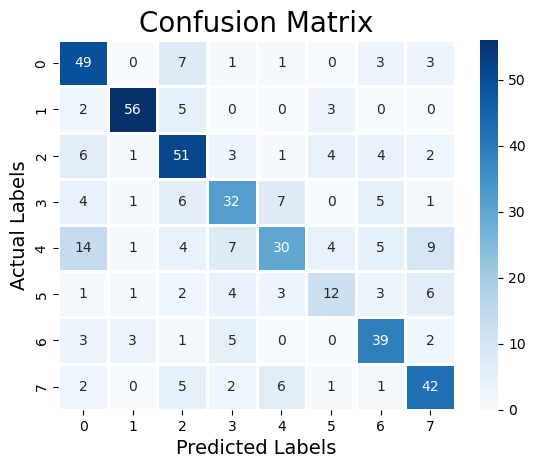

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.60      0.77      0.68        64
        calm       0.89      0.85      0.87        66
     disgust       0.63      0.71      0.67        72
     fearful       0.59      0.57      0.58        56
       happy       0.62      0.41      0.49        74
     neutral       0.50      0.38      0.43        32
         sad       0.65      0.74      0.69        53
   surprised       0.65      0.71      0.68        59

    accuracy                           0.65       476
   macro avg       0.64      0.64      0.64       476
weighted avg       0.65      0.65      0.65       476



In [41]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0         happy  03-01-06-02-02-02-15.wav
1       disgust  03-01-07-02-02-01-12.wav
2          calm  03-01-02-02-01-02-13.wav
3         angry  03-01-06-02-02-02-06.wav
4       fearful  03-01-06-02-01-01-19.wav
..          ...                       ...
471   surprised  03-01-03-01-01-01-01.wav
472     disgust  03-01-02-02-01-02-22.wav
473     disgust  03-01-07-02-01-01-23.wav
474     disgust  03-01-05-01-01-01-22.wav
475     fearful  03-01-04-02-01-01-15.wav

[476 rows x 2 columns]


# LIVE DEMO

In [42]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

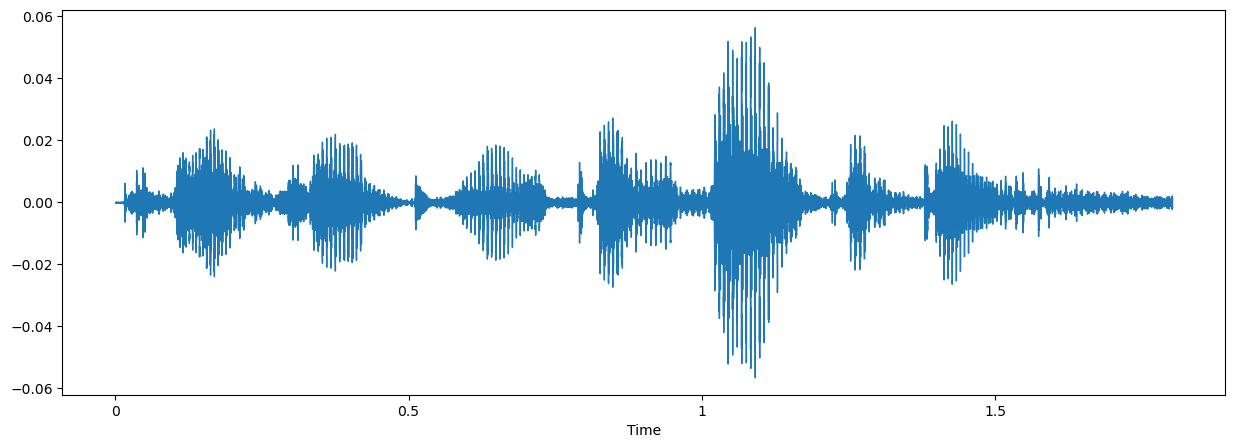

In [43]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load('/Users/praneethnpbmacpro/Downloads/RAVDESS/clean_speech/03-01-04-01-01-01-03.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob
from IPython.display import Audio

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

Audio(data=data, rate=sampling_rate)

In [44]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [45]:
## Appying extract_feature function on random file and then loading model to predict the result 
file = '/Users/praneethnpbmacpro/Downloads/RAVDESS/clean_speech/03-01-04-01-01-01-03.wav'
ans =[]
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)

Emotion_Voice_Detection_Model.predict(ans)

array(['sad'], dtype='<U9')